In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
import os
import re
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (confusion_matrix, classification_report,
                             accuracy_score, precision_score, recall_score, f1_score)
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\MD. AQUIB
[nltk_data]     AZMI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
STOPWORDS = set(stopwords.words('english'))

In [5]:
OlidData=pd.read_csv('OLIDv1.0/olid-training-v1.0.tsv', delimiter='\t', encoding='utf-8')

In [6]:
OlidData.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [7]:
OlidData.shape

(13240, 5)

In [8]:
OlidData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         13240 non-null  int64 
 1   tweet      13240 non-null  object
 2   subtask_a  13240 non-null  object
 3   subtask_b  4400 non-null   object
 4   subtask_c  3876 non-null   object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


In [9]:
OlidData.isnull().sum()

id              0
tweet           0
subtask_a       0
subtask_b    8840
subtask_c    9364
dtype: int64

In [10]:
OlidData.duplicated().sum()

0

In [11]:
# subtask_a has values 'OFF' (offensive) and 'NOT' (not offensive)
OlidData_a = OlidData[['id', 'tweet', 'subtask_a']].copy()
OlidData_a = OlidData_a[['tweet', 'subtask_a']].reset_index(drop=True)
OlidData_a['label'] = OlidData_a['subtask_a'].map({'NOT': 0, 'OFF': 1})
print(OlidData_a.label.value_counts())

label
0    8840
1    4400
Name: count, dtype: int64


In [12]:
# text cleaning function 
def clean_text(text):
    # Lowercase
    text = str(text).lower()
    # Replace user mentions and urls
    text = re.sub(r'@user', ' ', text)          # dataset token for mentions may be @USER
    text = re.sub(r'http\S+|www\.\S+', ' ', text)
    # remove hashtags symbol, keep the word
    text = re.sub(r'#', '', text)
    # remove punctuation except apostrophes
    text = re.sub(r"[^a-z0-9\s']", ' ', text)
    # collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

OlidData_a['clean_tweet'] = OlidData_a['tweet'].apply(clean_text)

In [13]:
# Train/test split
X = OlidData_a['clean_tweet']
y = OlidData_a['label']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [14]:
# TF-IDF vectorizer
tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_df=0.95,
    sublinear_tf=True,
    stop_words='english'
)

In [15]:
# Fit transformer on training text
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

### Multinomial Naive Bayes (MNB)

In [16]:
# Model Initialization & Training
mnb = MultinomialNB()
mnb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [17]:
# Prediction
mnb_pred = mnb.predict(X_test_tfidf)

In [18]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, mnb_pred))

Accuracy: 0.736404833836858


In [19]:
print("Precision:", precision_score(y_test, mnb_pred, average='macro'))

Precision: 0.754021236333053


In [20]:
print("Recall:", recall_score(y_test, mnb_pred, average='macro'))

Recall: 0.6242415672562731


In [21]:
print("F1 Score:", f1_score(y_test, mnb_pred, average='macro'))

F1 Score: 0.625720895270927


In [22]:
print("\nClassification Report:\n", classification_report(y_test, mnb_pred, target_names=['NOT','OFF']))


Classification Report:
               precision    recall  f1-score   support

         NOT       0.73      0.96      0.83      1768
         OFF       0.78      0.29      0.42       880

    accuracy                           0.74      2648
   macro avg       0.75      0.62      0.63      2648
weighted avg       0.75      0.74      0.69      2648



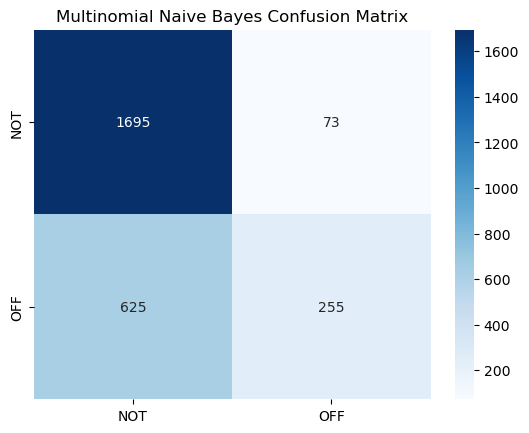

In [23]:
# Confusion Matrix
cm = confusion_matrix(y_test, mnb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=['NOT','OFF'], yticklabels=['NOT','OFF'])
plt.title("Multinomial Naive Bayes Confusion Matrix")
plt.show()

### Random Forest Classifier

In [ ]:
# Model Initialization & Training
rf = RandomForestClassifier(n_estimators=300, max_depth=None, class_weight='balanced', random_state=42)
rf.fit(X_train_tfidf, y_train)

In [ ]:
# Prediction
rf_pred = rf.predict(X_test_tfidf)

In [ ]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, rf_pred))

In [ ]:
print("Precision:", precision_score(y_test, rf_pred, average='macro'))

In [ ]:
print("Recall:", recall_score(y_test, rf_pred, average='macro'))

In [ ]:
print("F1 Score:", f1_score(y_test, rf_pred, average='macro'))

In [ ]:
print("\nClassification Report:\n", classification_report(y_test, rf_pred, target_names=['NOT','OFF']))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Greens", xticklabels=['NOT','OFF'], yticklabels=['NOT','OFF'])
plt.title("Random Forest Confusion Matrix")
plt.show()

### XGBoost Classifier

In [ ]:
# Model Initialization & Training
xgb = xgb.XGBClassifier(n_estimators=250, learning_rate=0.1, max_depth=5,
                    eval_metric='logloss', random_state=42, n_jobs=-1)
xgb.fit(X_train_tfidf, y_train)

In [ ]:
# Prediction
xgb_pred = xgb.predict(X_test_tfidf)

In [ ]:
# Evaluation
print("Accuracy:", accuracy_score(y_test, xgb_pred))

In [ ]:
print("Precision:", precision_score(y_test, xgb_pred, average='macro'))

In [ ]:
print("Recall:", recall_score(y_test, xgb_pred, average='macro'))

In [ ]:
print("F1 Score:", f1_score(y_test, xgb_pred, average='macro'))

In [ ]:
print("\nClassification Report:\n", classification_report(y_test, xgb_pred, target_names=['NOT','OFF']))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Oranges", xticklabels=['NOT','OFF'], yticklabels=['NOT','OFF'])
plt.title("XGBoost Confusion Matrix")
plt.show()